## Using Resnet50 for Transfer Learning and classify the tinyimagenet data



## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



## Importing the tiny imagenet Dataset

In [2]:
from google.colab import drive

drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2024-05-10 09:24:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-05-10 09:24:43--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  3.94MB/s    in 30s     

2024-05-10 09:25:13 (7.99 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.models import load_model
from keras.callbacks import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [5]:
train_datagen = ImageDataGenerator(
    rescale= 1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory( r'/content/tiny-imagenet-200/train', target_size=(32, 32), color_mode='rgb',
                                                    batch_size=256, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [7]:
test_datagen = ImageDataGenerator(
    rescale= 1./255)
test_generator = test_datagen.flow_from_directory( r'/content/tiny-imagenet-200/test', target_size=(32, 32), color_mode='rgb',
                                                    batch_size=256, class_mode='categorical', shuffle=True, seed=42)


Found 10000 images belonging to 1 classes.


In [8]:
x_test_all = []
y_test_all = []

# Loop over the generator until all validation data is exhausted
for i in range(int(len(test_generator))):
    x_batch, y_batch = next(test_generator)
    x_test_all.append(x_batch)
    y_test_all.append(y_batch)

# Concatenate all batches to get the entire validation set
X_test = np.concatenate(x_test_all)
Y_test = np.concatenate(y_test_all)


In [9]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(32,32),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=True, seed=42)


Found 10000 validated image filenames belonging to 200 classes.


In [10]:
# Initialize empty lists to store data and labels
x_train_all = []
y_train_all = []

# Get the total number of batches in the generator
total_batches = len(train_generator)

# Iterate over the generator to fetch all batches
for i in range(int(total_batches)):
    # Fetch one batch of data from the generator
    (x_batch, y_batch) = train_generator[i]

    # Append the batch to the lists
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate the batches to get the entire dataset
X_train = np.concatenate(x_train_all, axis=0)
Y_train = np.concatenate(y_train_all, axis=0)

# Print the shapes to verify
print("x_train shape:", X_train.shape)  # Shape of the input data
print("y_train shape:", Y_train.shape)  # Shape of the labels


x_train shape: (100000, 32, 32, 3)
y_train shape: (100000, 200)


In [11]:
x_val_all = []
y_val_all = []

# Loop over the generator until all validation data is exhausted
for i in range(int(len(validation_generator))):
    x_batch, y_batch = next(validation_generator)
    x_val_all.append(x_batch)
    y_val_all.append(y_batch)

# Concatenate all batches to get the entire validation set
x_test = np.concatenate(x_val_all)
y_test = np.concatenate(y_val_all)
print(x_test.shape)
print(y_test.shape)

(10000, 32, 32, 3)
(10000, 200)


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.models import load_model
from keras.callbacks import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [13]:

def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()

##  Plotting some images from the dataset

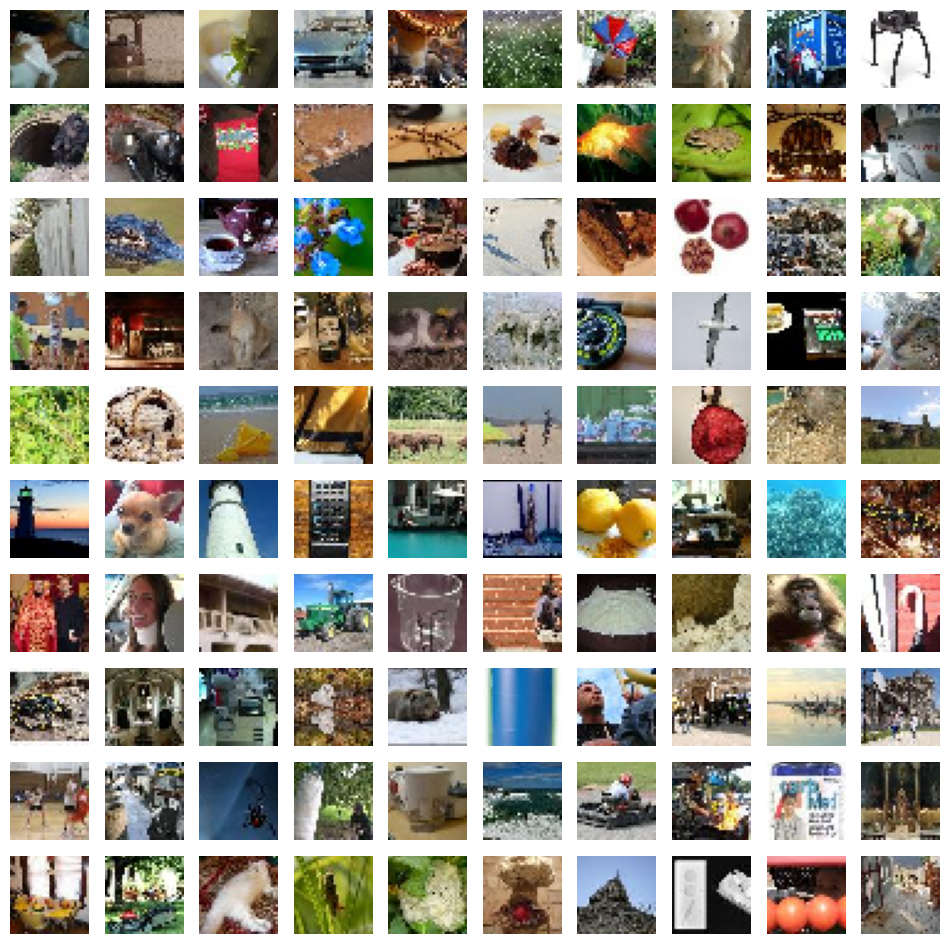

In [14]:
plt.figure(figsize=(12,12))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(X_train[i],cmap='gray')

## Splitting the train data again - we use the val set as test set and previous test set for final predictions

In [15]:
x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

##  Onehot encoding of the outputs

In [16]:
  x_train = x_train * 1.0/255

  x_val = x_val * 1.0/255

  x_test = x_test * 1.0/255

In [17]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(80000, 32, 32, 3) (20000, 32, 32, 3) (10000, 32, 32, 3)
(80000, 200) (20000, 200) (10000, 200)


##  Image Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)

##  Reduce Learning Rate if accuracy is not improving for 3 epochs

In [19]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)

##  Importing the Customnet Model

In [20]:
from keras.models import Sequential
from keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

def create_model2():
        model = Sequential()
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(10))    # num_classes = 10

        # Checking the model summary
        return model
customnetmodel=create_model2()
customnetmodel.load_weights("/content/drive/MyDrive/cifar10customnetmodelweights.h5")

In [21]:
for layer in customnetmodel.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
newmodel=Sequential()
for layer in customnetmodel.layers[:-1]:
       newmodel.add(layer)
for layer in newmodel.layers:
    layer.trainable =False
# add dropout layer and new output layer
newmodel.add(Dropout(0.5))
newmodel.add(Dense(200, activation='softmax'))
newmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                      

In [22]:
newmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                      

### Stochastic gradient descent optimizer with momentum.

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

Compile the model

In [25]:
newmodel.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

We now Train the model on images. we are also checking to see if validation accuracy doesnt improve we will reduce learning rate though the callback

In [26]:
result=newmodel.fit(
    train_datagen.flow(x_train, y_train, batch_size = 64),
    validation_data = (x_val, y_val),
    epochs = 10,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/10
1250/1250 [==============================] - 47s 35ms/step - loss: 5.5799 - accuracy: 0.0049 - val_loss: 5.3069 - val_accuracy: 0.0048 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 43s 34ms/step - loss: 5.5044 - accuracy: 0.0047 - val_loss: 5.3047 - val_accuracy: 0.0048 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 43s 34ms/step - loss: 5.4764 - accuracy: 0.0049 - val_loss: 5.3043 - val_accuracy: 0.0048 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 5.4556 - accuracy: 0.0054
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
1250/1250 [==============================] - 43s 34ms/step - loss: 5.4556 - accuracy: 0.0054 - val_loss: 5.3036 - val_accuracy: 0.0048 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 43s 34ms/step - loss: 5.4444 - accuracy: 0.0050 - val_loss: 5.3031 - val_accuracy: 0.0048 - lr: 6.0000e-04
Epoch 6/10
1250/1250 [================

In [33]:
newmodel.save_weights('/content/drive/MyDrive/tinyobjectnnetcustomnettransferlearningmy_model_weights.h5')


In [28]:
newmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                      

## Plot accuracy and Loss

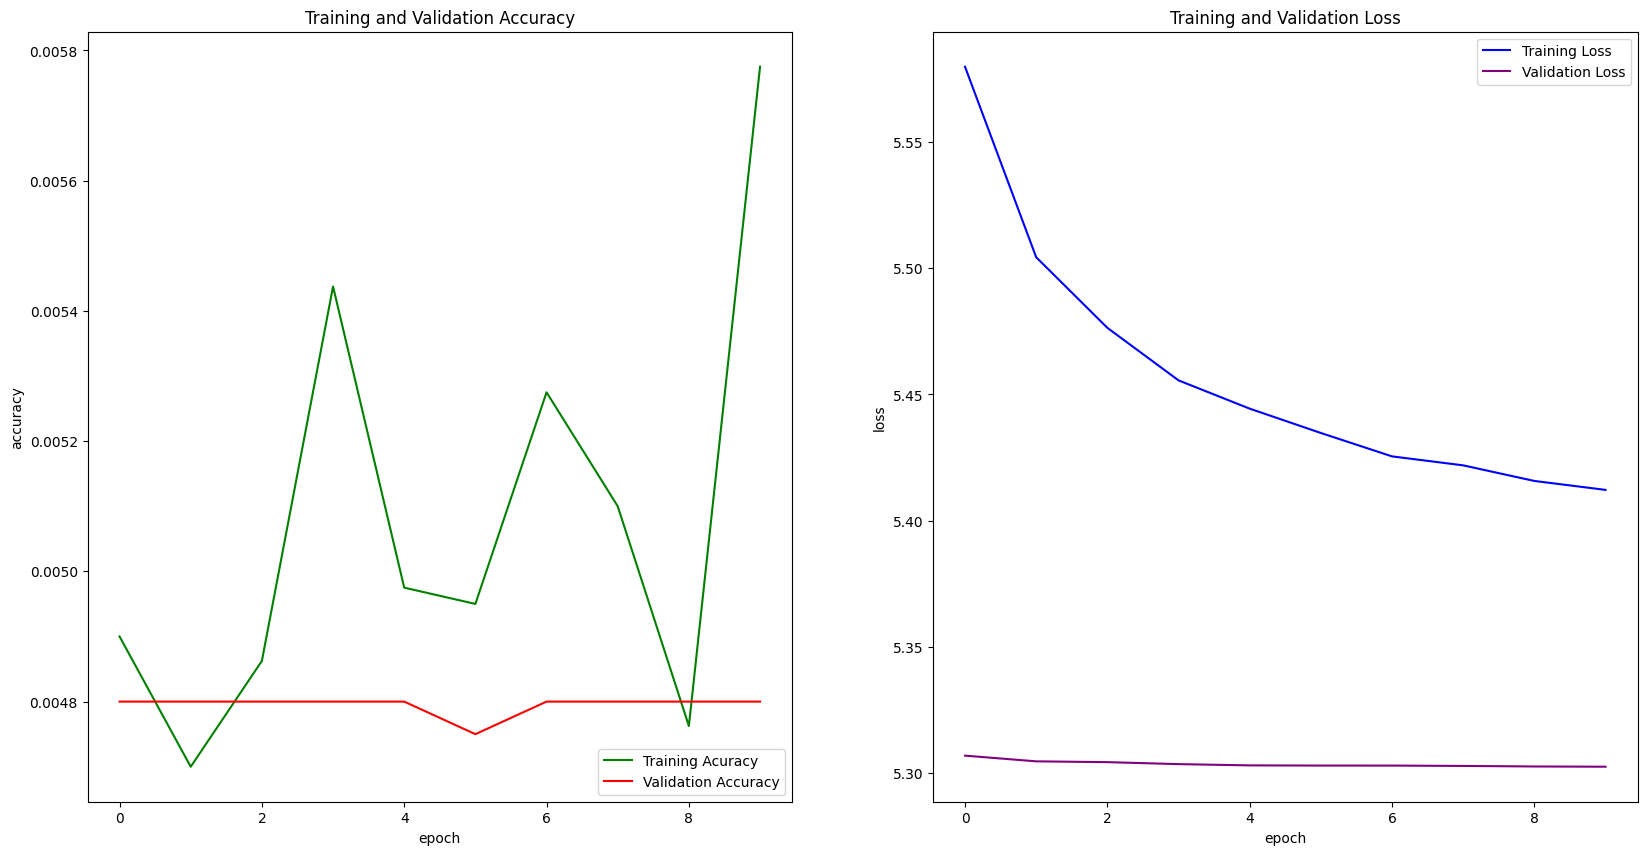

In [29]:
plot_acc_loss(result)


## Predictions,Accuracy and Confusion Matrix
### ** Requires modification for proper format **

In [30]:
y_pred = np.argmax(newmodel.predict(x_test), axis=-1)
y_test = np.argmax(y_test,axis =-1)
y_true = y_test.ravel()
print(y_pred.shape,y_true.shape)


313/313 [==============================] - 1s 3ms/step
(10000,) (10000,)


In [31]:
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

Testing Accuracy:  0.005


In [32]:
cm = confusion_matrix(y_true,y_pred)
cm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])